# **1. Required Libraries & Setting Global Parameters**

In [74]:
!pip install torchvision==0.10.0

     |████████████████████████████████| 22.1 MB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 831.4 MB 1.8 kB/s  eta 0:00:01     |█████▎                          | 137.4 MB 13.2 MB/s eta 0:00:53     |██████████▏                     | 263.6 MB 27.5 MB/s eta 0:00:21     |██████████▏                     | 265.2 MB 34.9 MB/s eta 0:00:17     |██████████▎                     | 268.2 MB 34.9 MB/s eta 0:00:17     |██████████▍                     | 269.7 MB 34.9 MB/s eta 0:00:17     |██████████▍                     | 271.2 MB 34.9 MB/s eta 0:00:17     |██████████▋                     | 274.5 MB 34.9 MB/s eta 0:00:16     |██████████▉                     | 282.8 MB 34.9 MB/s eta 0:00:16     |███████████                     | 287.6 MB 34.9 MB/s eta 0:00:16     |███████████▎                    | 292.3 MB 34.9 MB/s eta 0:00:16     |██████████████████▌             | 479.4 MB 17.4 MB/s eta 0:00:21     |██████████████████▉             | 488.6 MB 21.3 MB/s eta 0:00:17     |██████████████

In [77]:
import os
import time
import copy
import glob

# General Data Manipulation Libraries
import numpy as np
import pandas as pd

# Image Manipulation
import cv2
from skimage import exposure

# PyTorch Libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import torch.optim as optim

from torch.utils.data import DataLoader
import torchvision.datasets as datasets

# Plotting Libraries
import matplotlib.pyplot as plt

# Print PyTorch version
print(f'PyTorch Version {torch.__version__}')
print(f'Torchvision Version {torchvision.__version__}')

PyTorch Version 1.7.0
Torchvision Version 0.8.1


## **Global Parameters**

In [65]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'  
    torch.set_default_tensor_type('torch.FloatTensor')

In [66]:
# Batch Size
batch_size = 64
# Number of Classes of the Dataset
num_classes = 2
# Number of Epochs for Training
num_epochs = 10

In [67]:
print(f'This notebook is currently running on {device}.')

This notebook is currently running on cuda.


# **2. Exploratory data analysis**

## **Loading Dataset**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


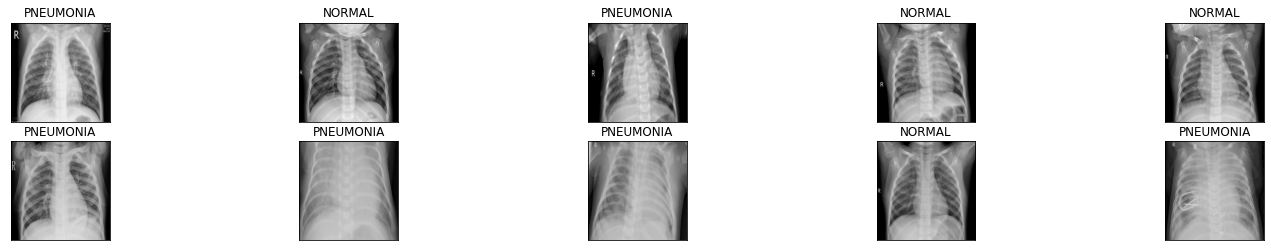

In [68]:
# Clearing CUDA cache
torch.cuda.empty_cache()

# Data File Directories
BASE_DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

# Normalization as per Pre-trained model (See Documentation on VGG PyTorch)
normalize = transforms.Normalize( mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225] )

# Loading Dataset for Visualization Purposes

# Transform for Unifromity of Displayed Image
viz_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

viz_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, 'train'), viz_transforms)
viz_dataloader = torch.utils.data.DataLoader(viz_dataset, batch_size=batch_size, shuffle=True)

# Visualization
dataiter = iter(viz_dataloader)
images, labels = dataiter.next()
images = images.numpy() 

labels.tolist()
labels = ['PNEUMONIA' if x==1 else 'NORMAL' for x in labels]

# Plotting
fig = plt.figure(figsize=(25,4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1,2,0)))
  ax.set_title(labels[idx])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


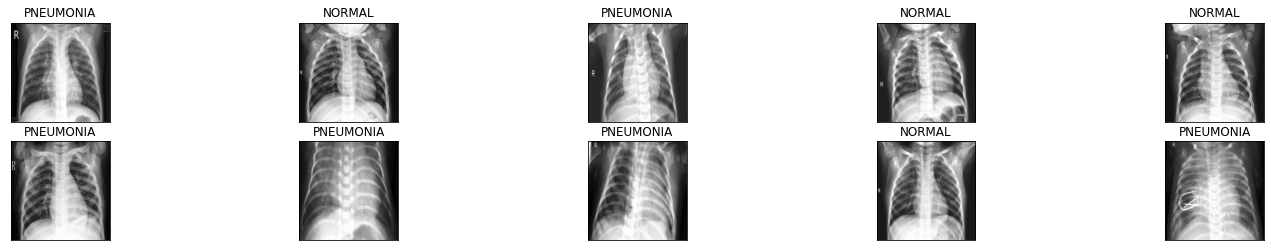

In [69]:
images = [exposure.equalize_hist(img) for img in images]
images = np.array(images)

fig2 = plt.figure(figsize=(25,4))

for idx in np.arange(10):
  ax2 = fig2.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1,2,0)))
  ax2.set_title(labels[idx])
  print()

In this dataset the test subfolder has vastly more examples of images than the val subfolder which has 8 images per class. This leads us to shift these two classification in order to better understand he progression of validation errors as training progresses.

In [78]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomEqualize(p=1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        #transforms.RandomEqualize(p=1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(BASE_DIR, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'test']}

AttributeError: module 'torchvision.transforms' has no attribute 'RandomEqualize'

# **3.  Loading & Fine-tuning Model**

We are using the Pre-trained VGG model trained on the ImageNet Dataset with 1000 classes. Our Dataset has only two classes this will require us to change the architecure of the VGG model to reflect this. We 

In [ ]:
# Load Pre-trained Model
vgg16 = models.vgg16(pretrained=True, progress=True)

In [ ]:
# Setting the Parameters of the Pre-trained model to be fixed i.e they are not going to be optimized
for param in vgg16.parameters():
    param.requires_grad = False

In [ ]:
# Removes Last Layer of Model
my_model = nn.Sequential(*list(vgg16.children())[:][:-1])

In [ ]:
# Modifying Last Layer of Model for our test case of 2 classes
vgg16.classifier[6] = nn.Linear(4096,num_classes)

In [ ]:
# Display the Model architecture
print(vgg16)

In [ ]:
# Send the model to Device
vgg16 = vgg16.to(device)

In [ ]:
# Setting the parameters to be learned and displaying them
params_to_update = []
for name,param in vgg16.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc)
            else:
                train_acc_history.append(epoch_acc)
                    

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [ ]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Train and evaluate
vgg16, hist_val , hist_train = train_model(vgg16, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

# **Results**

## **Plotting of Training and Validation Loss and Accuraccy**

In [ ]:
plt.plot(np.arange(num_epochs), hist_val, '-o', label = 'val')
plt.plot(np.arange(num_epochs), hist_train, '-o', label = 'train')
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(num_epochs))
plt.title('Plot of Training and Validation Accuracy')
plt.plot()

## **Save Parameter Dictionary of Model**

In [ ]:
torch.save(vgg16.state_dict(), '/kaggle/working/state_dict_model.pt')

# **Test Learned Model**

In [ ]:
# Transforms for Test Data
test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Loading Test Data
test_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, 'val'), test_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size= 1, shuffle=True)

In [ ]:
# Setting Model to Evaluate Only mode i.e for Batch Normalizatio and Dropout layers
vgg16.eval()

# Feeding Test Dataset to Model and displaying Accuraccy
correct_preds = 0
for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = vgg16(inputs)
    _, preds = torch.max(outputs, 1)
    correct_preds += torch.sum(preds == labels.data)
    print(f'Predicted label {preds} but actual label {labels}')
    
# Training Accuraccy calculation
test_acc = correct_preds.double() / len(test_dataloader.dataset)
print(f'Accuraccy on Test Data {test_acc}')